In [14]:
# Si ya las tienes, puedes saltarte esta celda.
%pip install pandas numpy pyarrow folium matplotlib seaborn boto3 python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [15]:
import boto3
import os
from dotenv import load_dotenv

# == CONFIGURA TUS KEYS AQUÍ ===
load_dotenv()

AWS_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("AWS_DEFAULT_REGION")

BUCKET_NAME = "glue-bucket-traffic-725895"
S3_PREFIX = "gold/TRAFFIC_DATA_GOLD_CLUSTERS_MX/"
LOCAL_DIR = "./gold_clusters"

os.makedirs(LOCAL_DIR, exist_ok=True)

s3 = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY,
    region_name=AWS_REGION
)

paginator = s3.get_paginator("list_objects_v2")

files_downloaded = 0
for page in paginator.paginate(Bucket=BUCKET_NAME, Prefix=S3_PREFIX):
    for obj in page.get("Contents", []):
        key = obj["Key"]
        
        if not key.endswith(".parquet"):
            continue
        
        local_path = os.path.join(LOCAL_DIR, key.split("/")[-1])
        
        print(f"Descargando: {key} -> {local_path}")
        s3.download_file(BUCKET_NAME, key, local_path)
        files_downloaded += 1

print("Listo! Archivos descargados:", files_downloaded)


Descargando: gold/TRAFFIC_DATA_GOLD_CLUSTERS_MX/part-00000-c4516aae-4b62-49cb-b5ca-c5db647fe872-c000.snappy.parquet -> ./gold_clusters/part-00000-c4516aae-4b62-49cb-b5ca-c5db647fe872-c000.snappy.parquet
Descargando: gold/TRAFFIC_DATA_GOLD_CLUSTERS_MX/part-00001-c4516aae-4b62-49cb-b5ca-c5db647fe872-c000.snappy.parquet -> ./gold_clusters/part-00001-c4516aae-4b62-49cb-b5ca-c5db647fe872-c000.snappy.parquet
Descargando: gold/TRAFFIC_DATA_GOLD_CLUSTERS_MX/part-00002-c4516aae-4b62-49cb-b5ca-c5db647fe872-c000.snappy.parquet -> ./gold_clusters/part-00002-c4516aae-4b62-49cb-b5ca-c5db647fe872-c000.snappy.parquet
Descargando: gold/TRAFFIC_DATA_GOLD_CLUSTERS_MX/part-00003-c4516aae-4b62-49cb-b5ca-c5db647fe872-c000.snappy.parquet -> ./gold_clusters/part-00003-c4516aae-4b62-49cb-b5ca-c5db647fe872-c000.snappy.parquet
Descargando: gold/TRAFFIC_DATA_GOLD_CLUSTERS_MX/part-00004-c4516aae-4b62-49cb-b5ca-c5db647fe872-c000.snappy.parquet -> ./gold_clusters/part-00004-c4516aae-4b62-49cb-b5ca-c5db647fe872-c000.

In [16]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import boto3

# --------- CONFIGURA ESTO ---------

# 1) Bucket donde quedaron los parquet de CLUSTERING (OUTPUT_PATH del job de Glue)
# BUCKET_NAME = "glue-bucket-traffic-725895"

# # 2) Prefijo en S3 donde están los parquet del clustering.
# #    Ejemplo típico después del job:
# #    s3://glue-bucket-traffic-725895/gold/TRAFFIC_DATA_GOLD_CLUSTERS/
# S3_PREFIX = "gold/TRAFFIC_DATA_GOLD_CLUSTERS/"

# # 3) Carpeta local donde se guardarán los parquet descargados
# LOCAL_DIR = "./gold_clusters"

# # Crear carpeta local si no existe
# os.makedirs(LOCAL_DIR, exist_ok=True)

# print("Bucket:", BUCKET_NAME)
# print("Prefijo S3:", S3_PREFIX)
# print("Carpeta local:", os.path.abspath(LOCAL_DIR))


In [17]:
# s3 = boto3.client("s3")

# def download_parquet_folder(bucket: str, prefix: str, local_dir: str):
#     """
#     Descarga todos los objetos .parquet dentro de un prefijo S3 a una carpeta local.
#     """
#     paginator = s3.get_paginator("list_objects_v2")
#     pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

#     count = 0
#     for page in pages:
#         for obj in page.get("Contents", []):
#             key = obj["Key"]
#             if not key.lower().endswith(".parquet"):
#                 continue

#             relative_path = key[len(prefix):]  # quitar el prefijo
#             local_path = os.path.join(local_dir, relative_path)

#             os.makedirs(os.path.dirname(local_path), exist_ok=True)
#             print(f"Descargando {key} -> {local_path}")
#             s3.download_file(bucket, key, local_path)
#             count += 1

#     print(f"Descarga completa. Archivos .parquet: {count}")

# download_parquet_folder(BUCKET_NAME, S3_PREFIX, LOCAL_DIR)


In [18]:
import pyarrow.parquet as pq

parquet_files = glob.glob(os.path.join(LOCAL_DIR, "**", "*.parquet"), recursive=True)
print("Parquet encontrados:", len(parquet_files))

if not parquet_files:
    raise RuntimeError("No se encontraron archivos .parquet en LOCAL_DIR. Revisa rutas y descarga.")

dfs = []
for fpath in parquet_files:
    df_part = pd.read_parquet(fpath)
    dfs.append(df_part)

df = pd.concat(dfs, ignore_index=True)
print("Shape total:", df.shape)
df.head()


Parquet encontrados: 72
Shape total: (1362, 16)


,id,Coordx,Coordy,cluster_id,traffic_01,traffic_07,traffic_09,traffic_11,traffic_13,traffic_15,traffic_17,traffic_19,traffic_21,traffic_23,traffic_03,traffic_05
0,627,-103.332741,20.698463,3,0.253893,0.273075,0.320277,0.310706,0.316767,0.323551,0.320987,0.330194,0.287245,0.271555,NaN,NaN
1,789,-103.305351,20.653551,3,0.351137,0.303387,0.283190,0.292885,0.295532,0.288955,0.287208,0.347503,0.297653,0.320754,NaN,NaN
2,342,-103.269981,20.649195,1,0.236303,0.254223,0.257433,0.255077,0.257424,0.255821,0.259950,0.265568,0.265654,0.257216,NaN,NaN
3,409,-103.363831,20.573915,3,0.275526,0.343265,0.360770,0.339287,0.343263,0.349140,0.327464,0.364933,0.337214,0.303794,NaN,NaN
4,451,-103.470639,20.547532,3,0.267180,0.351787,0.318262,0.278986,0.293696,0.279764,0.260379,0.292893,0.258170,0.253048,NaN,NaN


In [19]:
print(df.columns.tolist())


['id', 'Coordx', 'Coordy', 'cluster_id', 'traffic_01', 'traffic_07', 'traffic_09', 'traffic_11', 'traffic_13', 'traffic_15', 'traffic_17', 'traffic_19', 'traffic_21', 'traffic_23', 'traffic_03', 'traffic_05']


In [20]:
# Columnas mínimas necesarias
ID_COL = "id"
LON_COL = "Coordx"
LAT_COL = "Coordy"
CLUSTER_COL = "cluster_id"

# Todas las columnas de serie temporal (asumimos prefijo traffic_)
TRAFFIC_COLS = [c for c in df.columns if c.startswith("traffic_")]

print("Columnas de tráfico:", TRAFFIC_COLS)
print("Número de clusters:", df[CLUSTER_COL].nunique())
df[[ID_COL, LON_COL, LAT_COL, CLUSTER_COL] + TRAFFIC_COLS].head()


Columnas de tráfico: ['traffic_01', 'traffic_07', 'traffic_09', 'traffic_11', 'traffic_13', 'traffic_15', 'traffic_17', 'traffic_19', 'traffic_21', 'traffic_23', 'traffic_03', 'traffic_05']
Número de clusters: 4


,id,Coordx,Coordy,cluster_id,traffic_01,traffic_07,traffic_09,traffic_11,traffic_13,traffic_15,traffic_17,traffic_19,traffic_21,traffic_23,traffic_03,traffic_05
0,627,-103.332741,20.698463,3,0.253893,0.273075,0.320277,0.310706,0.316767,0.323551,0.320987,0.330194,0.287245,0.271555,NaN,NaN
1,789,-103.305351,20.653551,3,0.351137,0.303387,0.283190,0.292885,0.295532,0.288955,0.287208,0.347503,0.297653,0.320754,NaN,NaN
2,342,-103.269981,20.649195,1,0.236303,0.254223,0.257433,0.255077,0.257424,0.255821,0.259950,0.265568,0.265654,0.257216,NaN,NaN
3,409,-103.363831,20.573915,3,0.275526,0.343265,0.360770,0.339287,0.343263,0.349140,0.327464,0.364933,0.337214,0.303794,NaN,NaN
4,451,-103.470639,20.547532,3,0.267180,0.351787,0.318262,0.278986,0.293696,0.279764,0.260379,0.292893,0.258170,0.253048,NaN,NaN


In [38]:
import folium
from folium import Element
from folium.plugins import MarkerCluster

# 1. Filtrar coordenadas válidas
df_map = df.dropna(subset=[LAT_COL, LON_COL]).copy()
df_map[CLUSTER_COL] = df_map[CLUSTER_COL].astype(int)

print("Filas originales:", len(df))
print("Filas con coordenadas válidas:", len(df_map))

# 2. Centro del mapa
center_lat = df_map[LAT_COL].mean()
center_lon = df_map[LON_COL].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="OpenStreetMap")

# 3. Colores por cluster
CLUSTER_COLORS = {
    0: "#ff7f0e",  # Cluster 0: tráfico medio/alto (naranja)
    1: "#d62728",  # Cluster 1: tráfico alto (rojo)
    2: "#2ca02c",  # Cluster 2: tráfico muy bajo (verde)
    3: "#1f77b4",  # Cluster 3: tráfico medio/bajo (azul)
}

# 4. Activar agrupamiento (sin icon_create_function custom)
marker_cluster = MarkerCluster(disableClusteringAtZoom=14).add_to(m)

# 5. Dibujar puntos de colores dentro del cluster
for _, row in df_map.iterrows():
    cid = int(row[CLUSTER_COL])
    color = CLUSTER_COLORS.get(cid, "#000000")  # negro si algo raro

    folium.CircleMarker(
        location=[row[LAT_COL], row[LON_COL]],
        radius=7,
        color=color,        # borde
        weight=2,
        fill=True,
        fill_color=color,   # relleno
        fill_opacity=0.95,
        popup=f"id: {row[ID_COL]}, Cluster: {cid}",
    ).add_to(marker_cluster)

# 6. Leyenda fija
legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 220px;
    z-index:9999;
    background:white;
    border:2px solid grey;
    border-radius:8px;
    padding:10px;">
    <strong>Clusters de Tráfico</strong><br><br>
    <i style="background:#d62728; width:12px; height:12px; float:left;
              margin-right:8px;"></i> Cluster 1: Tráfico alto<br>
    <i style="background:#ff7f0e; width:12px; height:12px; float:left;
              margin-right:8px;"></i> Cluster 0: Medio/alto<br>
    <i style="background:#1f77b4; width:12px; height:12px; float:left;
              margin-right:8px;"></i> Cluster 3: Medio/bajo<br>
    <i style="background:#2ca02c; width:12px; height:12px; float:left;
              margin-right:8px;"></i> Cluster 2: Muy bajo<br>
</div>
"""
m.get_root().html.add_child(Element(legend_html))

m.save("traffic_clusters_map.html")
print("Mapa guardado en traffic_clusters_map.html")


Filas originales: 1362
Filas con coordenadas válidas: 1348
Mapa guardado en traffic_clusters_map.html


In [22]:
output_map_path = "traffic_clusters_map.html"
m.save(output_map_path)
print("Mapa guardado en:", os.path.abspath(output_map_path))


Mapa guardado en: /Users/jpdealba/Documents/UP/big_data/proyecto/traffic_clusters_map.html


In [23]:
# Convertimos las columnas de tráfico a numérico por si viene algo raro
for col in TRAFFIC_COLS:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Agrupar por cluster y promediar
cluster_means = df.groupby(CLUSTER_COL)[TRAFFIC_COLS].mean().sort_index()
cluster_means


,traffic_01,traffic_07,traffic_09,traffic_11,traffic_13,traffic_15,traffic_17,traffic_19,traffic_21,traffic_23,traffic_03,traffic_05
cluster_id,,,,,,,,,,,,
0,0.319056,0.307662,0.414408,0.426115,0.314048,0.322996,0.316412,0.324696,0.315580,0.299678,0.290819,0.285888
1,0.287162,0.273363,0.251921,0.241695,0.285488,0.302044,0.305500,0.320117,0.308791,0.289482,0.372549,0.343741
2,0.049634,0.043202,0.064802,0.062101,0.055504,0.064491,0.063408,0.063663,0.064165,0.055691,0.054998,0.042816
3,0.295156,0.266696,0.308439,0.308660,0.292715,0.299994,0.284874,0.307204,0.287243,0.284698,0.203225,0.179857


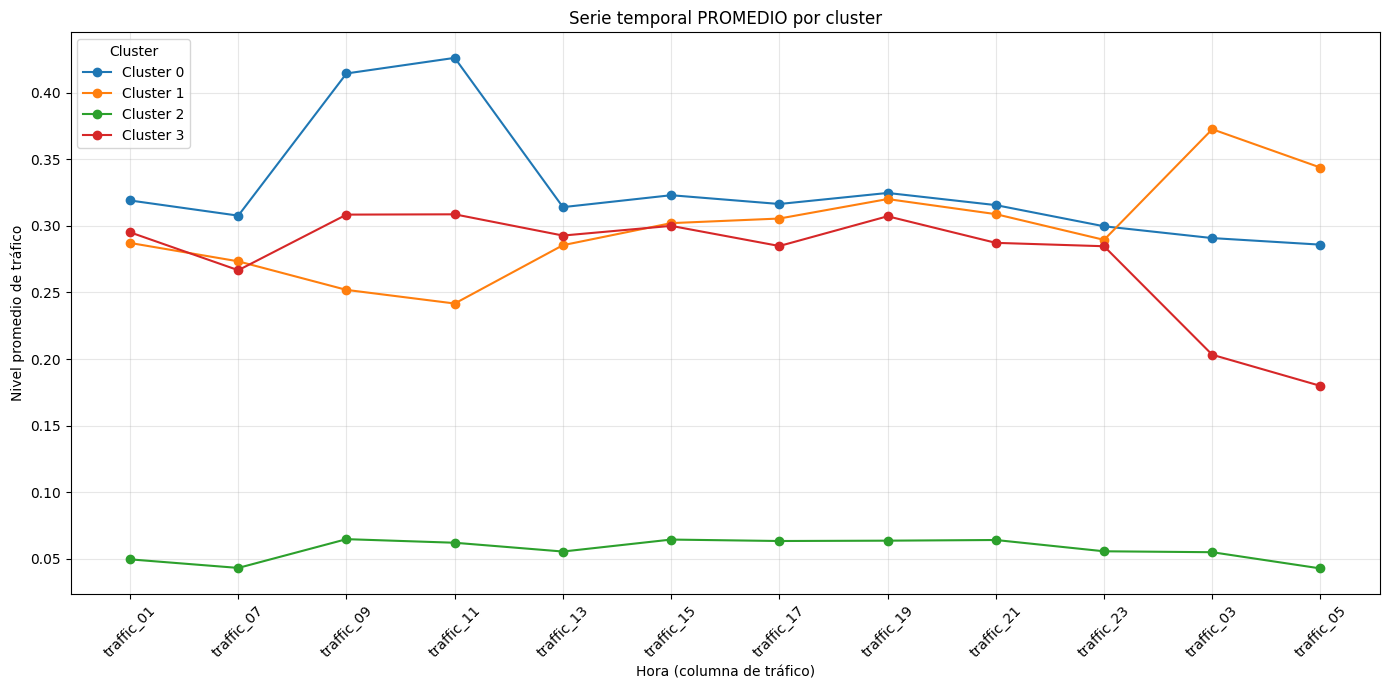

In [27]:
plt.figure(figsize=(14, 7))

x = list(range(len(TRAFFIC_COLS)))
x_labels = TRAFFIC_COLS

for cluster_id, row in cluster_means.iterrows():
    plt.plot(
        x,
        row.values,
        marker="o",
        label=f"Cluster {cluster_id}"
    )

plt.xticks(ticks=x, labels=x_labels, rotation=45)
plt.title("Serie temporal PROMEDIO por cluster")
plt.xlabel("Hora (columna de tráfico)")
plt.ylabel("Nivel promedio de tráfico")
plt.grid(True, alpha=0.3)
plt.legend(title="Cluster")
plt.tight_layout()


fname = os.path.join("figures_clusters", f"cluster_all.png")
plt.savefig(fname, dpi=150)
plt.show()
plt.close()


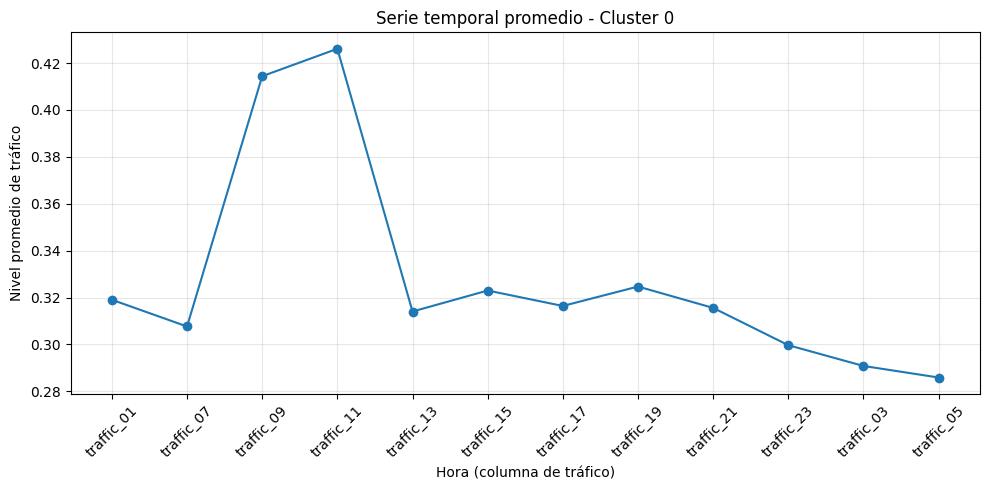

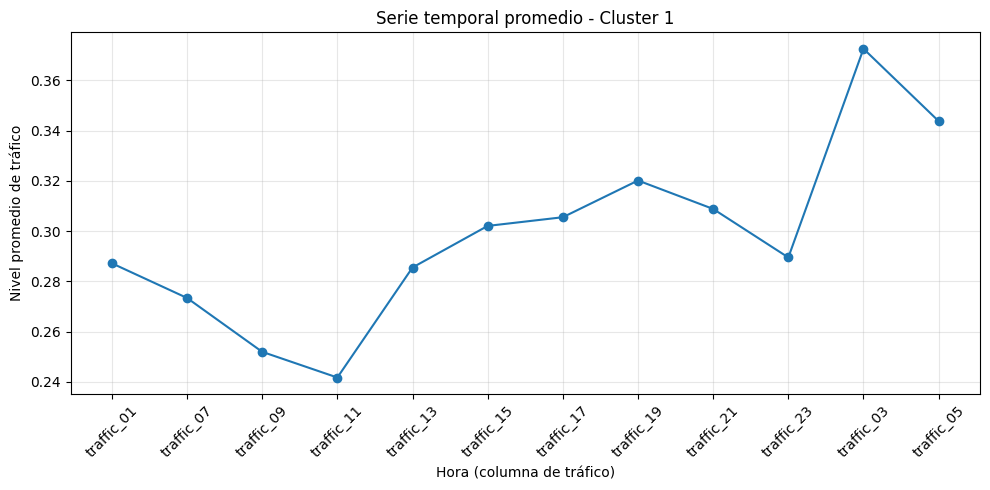

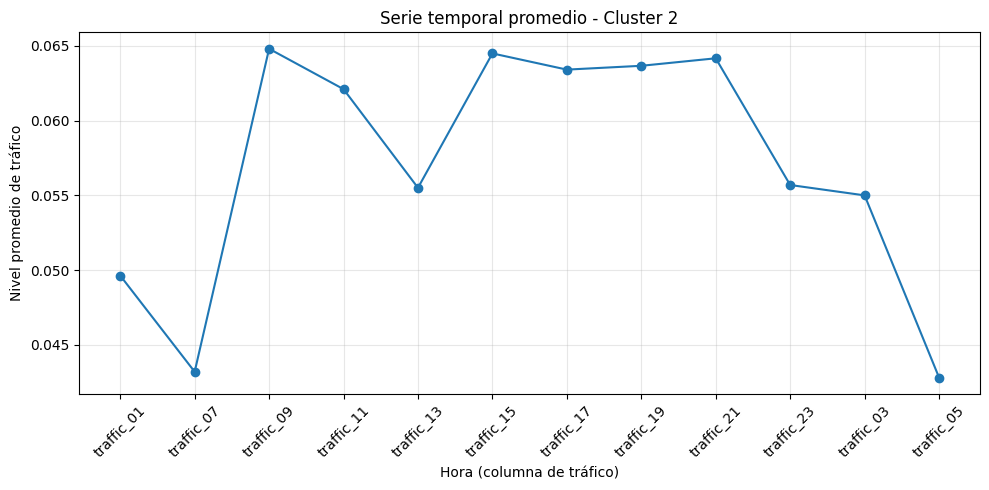

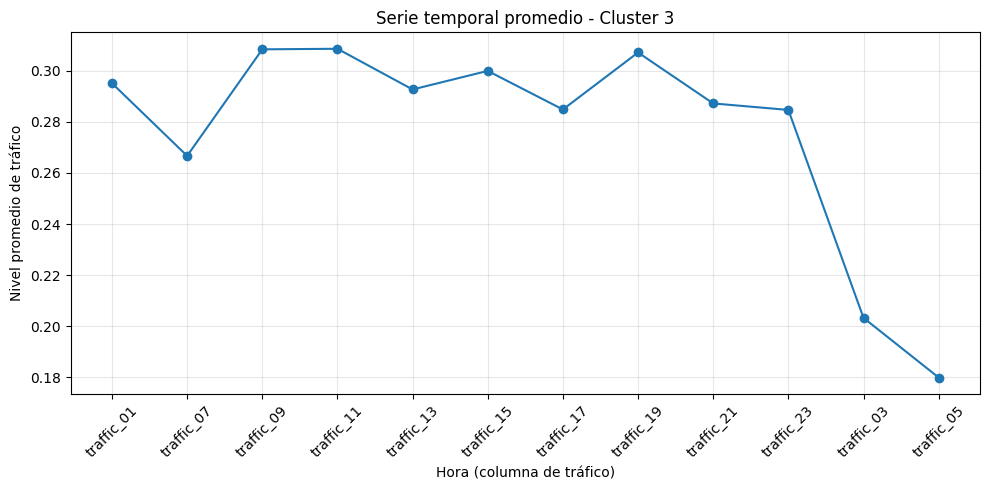

In [25]:
for cluster_id, row in cluster_means.iterrows():
    plt.figure(figsize=(10, 5))
    x = list(range(len(TRAFFIC_COLS)))
    plt.plot(x, row.values, marker="o")
    plt.xticks(ticks=x, labels=TRAFFIC_COLS, rotation=45)
    plt.title(f"Serie temporal promedio - Cluster {cluster_id}")
    plt.xlabel("Hora (columna de tráfico)")
    plt.ylabel("Nivel promedio de tráfico")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [26]:
import os

os.makedirs("figures_clusters", exist_ok=True)

for cluster_id, row in cluster_means.iterrows():
    plt.figure(figsize=(10, 5))
    x = list(range(len(TRAFFIC_COLS)))
    plt.plot(x, row.values, marker="o")
    plt.xticks(ticks=x, labels=TRAFFIC_COLS, rotation=45)
    plt.title(f"Serie temporal promedio - Cluster {cluster_id}")
    plt.xlabel("Hora (columna de tráfico)")
    plt.ylabel("Nivel promedio de tráfico")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    fname = os.path.join("figures_clusters", f"cluster_{cluster_id}.png")
    plt.savefig(fname, dpi=150)
    plt.close()
    print("Guardada figura:", fname)


Guardada figura: figures_clusters/cluster_0.png
Guardada figura: figures_clusters/cluster_1.png
Guardada figura: figures_clusters/cluster_2.png
Guardada figura: figures_clusters/cluster_3.png
